In [1]:
# Add related paths to system path
import sys
sys.path.append("../src")

import numpy as np
import pandas
import matplotlib.pyplot as plt
from models import FDBaseline, PDABaseline, CDABaseline, LinearUCB, LinearUCBNewRewards, LassoBandit
from utils import mean_confidence_interval
from evaluate import Evaluator

In [2]:
# Load data
data = pandas.read_csv("../data/data.csv", delimiter=',')
print(data.shape)

(5528, 88)


In [3]:
# Define baseline models
fixed = FDBaseline(1) # Define fixed dosage to be 1 (5mg / day)
pharm = PDABaseline()
clinic = CDABaseline()

In [4]:
# Get data for all baselines

# Fixed dosage baseline
fixed_features = fixed.get_features(data)

# Pharmacogenetic dosage baseline
pharm_features = pharm.get_features(data)

# Clinical dosage baseline
clinic_features = clinic.get_features(data)

# Get targets for each set (same targets for each baseline)
targets = fixed.get_targets(data)

In [5]:
# Define evaluators for each model
fixed_eval = Evaluator(fixed)
pharm_eval = Evaluator(pharm)
clinic_eval = Evaluator(clinic)

Fraction of correct decisions: 0.611794500723589


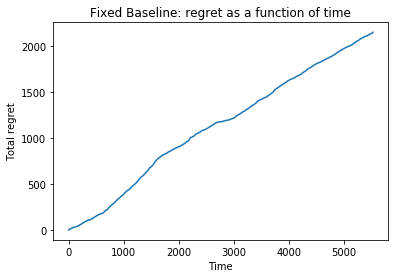

In [6]:
# Evaluate fixed baseline
fixed_predictions = fixed.predict(fixed_features)
fixed_acc = fixed_eval.accuracy(fixed_predictions, targets.values)
print("Fraction of correct decisions: " + str(fixed_acc))

fixed_regret = fixed_eval.regret(fixed_predictions, targets.values)
plt.plot(range(fixed_regret.shape[0]), fixed_regret)
plt.title("Fixed Baseline: regret as a function of time")
plt.xlabel("Time")
plt.ylabel("Total regret")
plt.show()

Fraction of correct decisions: 0.6864387593389178


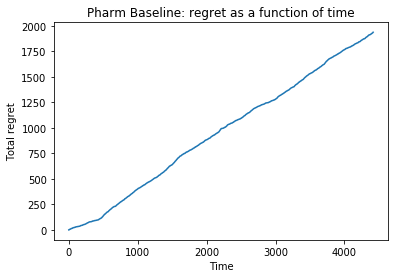

In [7]:
# Evaluate Pharmacogenetic baseline
pharm_predictions = pharm.predict(pharm_features.values[~np.isnan(pharm_features).any(axis=1)])
pharm_acc = pharm_eval.accuracy(pharm_predictions, targets.values[~np.isnan(pharm_features).any(axis=1)])
print("Fraction of correct decisions: " + str(pharm_acc))

pharm_regret = fixed_eval.regret(pharm_predictions, targets.values)
plt.plot(range(pharm_regret.shape[0]), pharm_regret)
plt.title("Pharm Baseline: regret as a function of time")
plt.xlabel("Time")
plt.ylabel("Total regret")
plt.show()

Fraction of correct decisions: 0.649083088068825


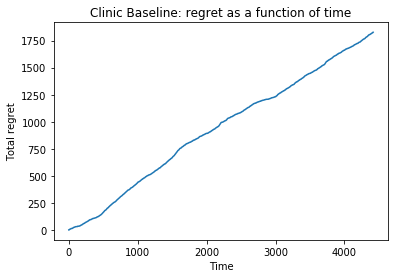

In [8]:
# Evaluate Clinical baseline
clinic_predictions = clinic.predict(clinic_features.values[~np.isnan(clinic_features).any(axis=1)])
clinic_acc = clinic_eval.accuracy(clinic_predictions, targets.values[~np.isnan(clinic_features).any(axis=1)])
print("Fraction of correct decisions: " + str(clinic_acc))

clinic_regret = fixed_eval.regret(clinic_predictions, targets.values)
plt.plot(range(clinic_regret.shape[0]), clinic_regret)
plt.title("Clinic Baseline: regret as a function of time")
plt.xlabel("Time")
plt.ylabel("Total regret")
plt.show()

In [22]:
# Linear UCB Model
linear_UCB = LinearUCB(num_arms=3, alpha=0.5)
linear_UCB_features = linear_UCB.get_features(data)

num_examples = linear_UCB_features.values[~np.isnan(linear_UCB_features).any(axis=1)].shape[0]
linear_UCB_regret = np.zeros((10, num_examples+1))
linear_UCB_incorrect = np.zeros((10, int(np.ceil(num_examples/100.0)+1)))

for i in range(10):
    cur_linear_UCB_regret, cur_linear_UCB_incorrect = linear_UCB.train(linear_UCB_features.values[~np.isnan(linear_UCB_features).any(axis=1)], targets.values[~np.isnan(linear_UCB_features).any(axis=1)])
    linear_UCB_regret[i] = np.array(cur_linear_UCB_regret)
    linear_UCB_incorrect[i] = np.array(cur_linear_UCB_incorrect)
    

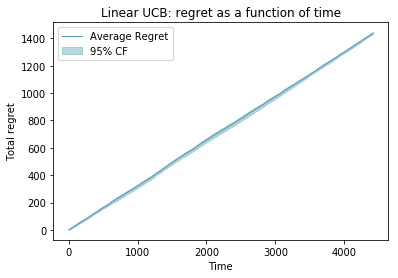

In [23]:
mean_linear_UCB_regret = np.zeros((num_examples+1,))
lower_bound_linear_UCB_regret = np.zeros((num_examples+1,))
upper_bound_linear_UCB_regret = np.zeros((num_examples+1,))

for i in range(linear_UCB_regret.shape[1]):
    mean, lower_bound, upper_bound = mean_confidence_interval(linear_UCB_regret[:,i], confidence=0.95)
    mean_linear_UCB_regret[i] = mean
    lower_bound_linear_UCB_regret[i] = lower_bound
    upper_bound_linear_UCB_regret[i] = upper_bound

plt.clf()
plt.plot(range(mean_linear_UCB_regret.shape[0]), mean_linear_UCB_regret, lw=1, color='#539caf', alpha=1, label="Average Regret")
plt.fill_between(range(lower_bound_linear_UCB_regret.shape[0]), lower_bound_linear_UCB_regret, upper_bound_linear_UCB_regret, color='#539caf', alpha=0.4, label="95% CF")
plt.title("Linear UCB: regret as a function of time")
plt.xlabel("Time")
plt.ylabel("Total regret")
plt.legend()
plt.show()


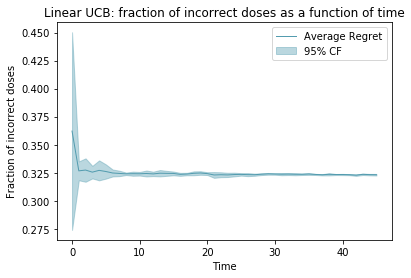

In [24]:
x_axis = []
np.floor(len(linear_UCB_incorrect))
for i in range(len(linear_UCB_incorrect)-1):
    x_axis.append(i*100)
x_axis.append(linear_UCB_features.values[~np.isnan(linear_UCB_features).any(axis=1)].shape[0])


mean_linear_UCB_incorrect = np.zeros((int(np.ceil(num_examples/100.0)+1,)))
lower_bound_linear_UCB_incorrect = np.zeros((int(np.ceil(num_examples/100.0)+1,)))
upper_bound_linear_UCB_incorrect = np.zeros((int(np.ceil(num_examples/100.0)+1,)))

for i in range(linear_UCB_incorrect.shape[1]):
    mean, lower_bound, upper_bound = mean_confidence_interval(linear_UCB_incorrect[:,i], confidence=0.95)
    mean_linear_UCB_incorrect[i] = mean
    lower_bound_linear_UCB_incorrect[i] = lower_bound
    upper_bound_linear_UCB_incorrect[i] = upper_bound

plt.clf()
plt.plot(range(mean_linear_UCB_incorrect.shape[0]), mean_linear_UCB_incorrect, lw=1, color='#539caf', alpha=1, label="Average Regret")
plt.fill_between(range(lower_bound_linear_UCB_incorrect.shape[0]), lower_bound_linear_UCB_incorrect, upper_bound_linear_UCB_incorrect, color='#539caf', alpha=0.4, label="95% CF")
plt.title("Linear UCB: fraction of incorrect doses as a function of time")
plt.xlabel("Time")
plt.ylabel("Fraction of incorrect doses")
plt.legend()
plt.show()

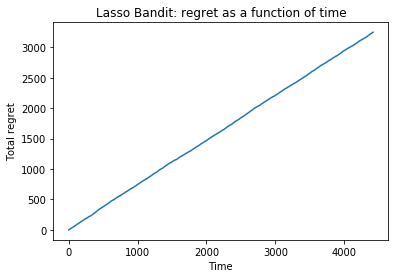

0.2644328729907177


In [11]:
# Lasso Model
lasso = LassoBandit(num_arms=3, lambda1=0.05, lambda2=0.05, h=5, q=1)
lasso_features = lasso.get_features(data)
# lasso_regret, lasso_incorrect = lasso.train(lasso_features.values[~np.isnan(lasso_features).any(axis=1)], targets.values[~np.isnan(lasso_features).any(axis=1)])
lasso_regret = lasso.train(lasso_features.values[~np.isnan(lasso_features).any(axis=1)], targets.values[~np.isnan(lasso_features).any(axis=1)])
plt.plot(range(lasso_regret.shape[0]), lasso_regret)
plt.title("Lasso Bandit: regret as a function of time")
plt.xlabel("Time")
plt.ylabel("Total regret")
plt.show()

print(1 - lasso_regret[len(lasso_regret) -1] / (len(lasso_regret)-1))


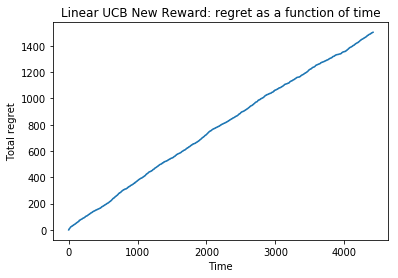

0.659723794430609


In [12]:
# Linear UCB Model with new reward structure
linear_UCB_new_reward = LinearUCBNewRewards(num_arms=3, alpha=0.5)
linear_UCB_new_reward_features = linear_UCB_new_reward.get_features(data)
linear_UCB_new_reward_regret, linear_UCB_new_reward_incorrect = linear_UCB_new_reward.train(linear_UCB_new_reward_features.values[~np.isnan(linear_UCB_new_reward_features).any(axis=1)], targets.values[~np.isnan(linear_UCB_new_reward_features).any(axis=1)])
plt.plot(range(linear_UCB_new_reward_regret.shape[0]), linear_UCB_new_reward_regret)
plt.title("Linear UCB New Reward: regret as a function of time")
plt.xlabel("Time")
plt.ylabel("Total regret")
plt.show()

print(1 - linear_UCB_new_reward_regret[len(linear_UCB_new_reward_regret) -1] / (len(linear_UCB_new_reward_regret)-1))